# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
 -1
  1
 -1
  1
  1
 -1
  1
  ⋮
 -1
  1
 -1
 -1
  1
  1
 -1
 -1
 -1

### We create a function to visualize the data

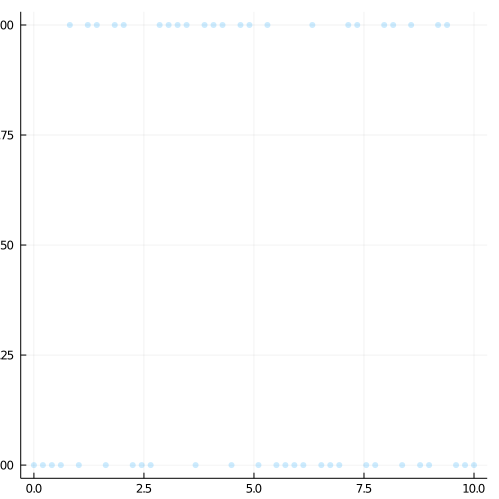

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.827284 seconds (1.87 M allocations: 106.803 MiB, 99.47% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [1.0607295524388716, 0.9942807227390001, 0.9046837719290687, 0.804983454697636, 0.713129855913821, 0.6460002037020693, 0.6103276215765122, 0.6000009350518793, 0.6027264561743876, 0.6095072259711373  …  0.6003960809668165, 0.5995800973792373, 0.6003596030541671, 0.6089680167526882, 0.631723272684204, 0.6715659670242978, 0.726338723373559, 0.7895790752649411, 0.8530427315120025, 0.9094922427151235], θ = [0.22892728733414916, 0.2312552283625096, 0.23423772366601883, 0.23732100184814525, 0.23991755908665183, 0.241654029856607, 0.24251816259974074, 0.2427604885954154, 0.24269687671654172, 0.2425375437251399  …  0.24275128152987993, 0.24277028854915209, 0.24275213169921517, 0.24255026990252693, 0.24200486653248138, 0.24100940880635727, 0.23955946638548073, 0.23777345248413947, 0.23586747490496987, 0.2340825338263887]), opt_state = (NamedTuple(),), hypero

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:29
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:17
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:31
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:08
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:54
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:45
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:22
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.6240196954901873, -1.4337229387932284, -1.1431504214309827, -0.7594701764910251, -0.3468585302054241, 0.08078833650058415, 0.49342064146563225, 0.8154621495431364, 1.0231010598379608, 1.0319957401194557  …  0.5769995878703627, 0.6997350319559428, 0.7061104433025809, 0.5874633441532382, 0.387185847615192, 0.07753413104896034, -0.22571351595234268, -0.530461057342553, -0.7498528704209015, -0.9139973157778389]]
 [[-0.12654539400476172, -0.2010952577496964, -0.22931172309393028, -0.2010809005118534, -0.08666724591327551, 0.04392905440513806, 0.1986453386566681, 0.3361260611482957, 0.4332217180565787, 0.45237022117418474  …  0.1583014386065105, 0.36485913413469023, 0.5294965749328325, 0.6082563028814927, 0.6386799906567171, 0.6305337879314414, 0.594532120909482, 0.5426617768408414, 0.5049822177048451, 0.46107642100572077]]
 [[-1.6883067337789948, -1.4608380788690862, -1.2341723685612584, -1.0045044134103576, -0.7160302078604766, -0.4362122

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

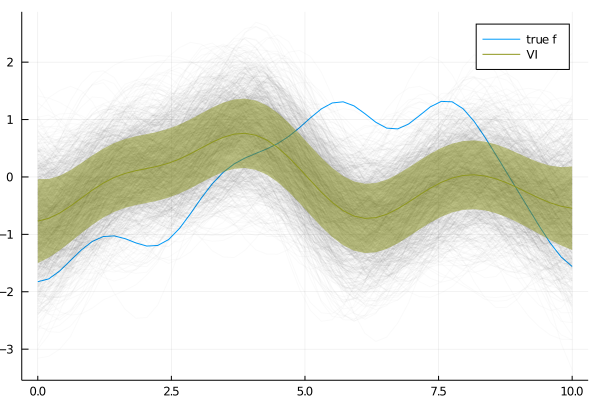

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

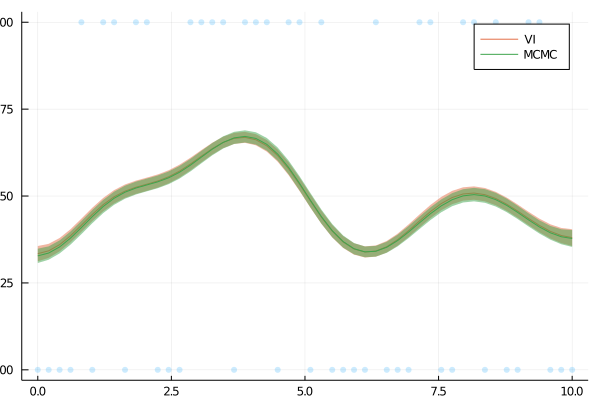

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*